In [23]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [24]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [25]:
NUM_CLASSES = 6

# Dataset reading

In [26]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [27]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [29]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [30]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_2 (Dropout)         (None, 42)                0         
                                                                 
 dense_3 (Dense)             (None, 20)                860       
                                                                 
 dropout_3 (Dropout)         (None, 20)                0         
                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
 dense_5 (Dense)             (None, 6)                 66        
                                                                 
Total params: 1136 (4.44 KB)
Trainable params: 1136 (4.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [31]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [32]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [33]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000


33/35 [===========================>..] - ETA: 0s - loss: 1.7516 - accuracy: 0.2585
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
35/35 [==============================] - 2s 16ms/step - loss: 1.7491 - accuracy: 0.2601 - val_loss: 1.6630 - val_accuracy: 0.3113
Epoch 2/1000
18/35 [==============>...............] - ETA: 0s - loss: 1.6497 - accuracy: 0.3016

c:\Users\joris\miniconda3\envs\p39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


29/35 [=======================>......] - ETA: 0s - loss: 1.6290 - accuracy: 0.3120
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
35/35 [==============================] - 0s 7ms/step - loss: 1.6235 - accuracy: 0.3109 - val_loss: 1.5485 - val_accuracy: 0.3577
Epoch 3/1000
33/35 [===========================>..] - ETA: 0s - loss: 1.5365 - accuracy: 0.3447
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
35/35 [==============================] - 0s 8ms/step - loss: 1.5350 - accuracy: 0.3450 - val_loss: 1.4446 - val_accuracy: 0.4328
Epoch 4/1000
31/35 [=========================>....] - ETA: 0s - loss: 1.4516 - accuracy: 0.3939
Epoch 4: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
35/35 [==============================] - 0s 9ms/step - loss: 1.4515 - accuracy: 0.3928 - val_loss: 1.3459 - val_accuracy: 0.4874
Epoch 5/1000
18/35 [==============>...............] - ETA: 0s - loss: 1.4173 - accuracy: 0.4093
Epoch 5: savin

In [34]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

12/12 [==============================] - 0s 7ms/step - loss: 0.3329 - accuracy: 0.9461


In [35]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [36]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 80ms/step
[8.2614642e-01 9.1850214e-02 1.1858013e-03 8.0468304e-02 4.9083246e-07
 3.4871619e-04]
0


# Confusion matrix

46/46 [==============================] - 0s 3ms/step


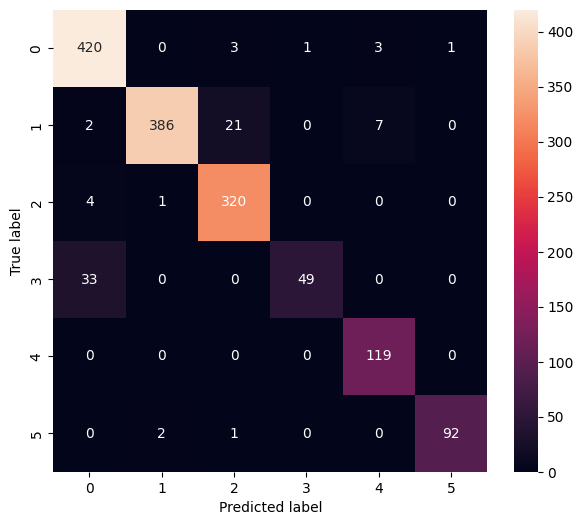

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       428
           1       0.99      0.93      0.96       416
           2       0.93      0.98      0.96       325
           3       0.98      0.60      0.74        82
           4       0.92      1.00      0.96       119
           5       0.99      0.97      0.98        95

    accuracy                           0.95      1465
   macro avg       0.95      0.91      0.92      1465
weighted avg       0.95      0.95      0.94      1465



In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [38]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

c:\Users\joris\miniconda3\envs\p39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [39]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmphc1g1v_9\assets


INFO:tensorflow:Assets written to: C:\Users\joris\AppData\Local\Temp\tmphc1g1v_9\assets


6660

# Inference test

In [40]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [41]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [42]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [43]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [44]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[8.2614648e-01 9.1850266e-02 1.1858003e-03 8.0468304e-02 4.9083155e-07
 3.4871654e-04]
0
